In [80]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [81]:
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.16.1


## Prepare Dataset

In [82]:
train_df_path ='../07. Pemodelan Data (Data Mining)/dataset/balanced_train_data.csv'


In [83]:
train_df = pd.read_csv(train_df_path, sep=',', header=None, usecols=[0,1], skiprows=1)

train_df.columns = ['full_text', 'emotion']

In [84]:
train_df.head(10)

,full_text,emotion
0,"['wakil', 'ketua', 'komisi', 'i', 'dpr', 'utut...",Neutral
1,"['kemnaker', 'rumah', 'sakit', 'bersinergi', '...",Neutral
2,"['very', 'interesting', 'comment', 'sheds', 's...",Neutral
3,"['distribusi', 'logistik', 'pemilu', 'tahap', ...",Neutral
4,"['well', 'it', 'is', 'geopolitics', 'you', 'se...",Neutral
5,"['bisa', 'om', 'tidak', 'ikutan', 'terkait', '...",Neutral
6,"['charta', 'politik', 'lembaga', 'survey', 'su...",Neutral
7,"['normal', 'la', 'saya', 'kena', 'reject']",Neutral
8,"['pak', 'anies', 'cak', 'imin', 'kombinasi', '...",Neutral
9,"['dispenser', 'beras', 'serbaguna', 'ukuran', ...",Neutral


In [85]:
train_df.head(10)

,full_text,emotion
0,"['wakil', 'ketua', 'komisi', 'i', 'dpr', 'utut...",Neutral
1,"['kemnaker', 'rumah', 'sakit', 'bersinergi', '...",Neutral
2,"['very', 'interesting', 'comment', 'sheds', 's...",Neutral
3,"['distribusi', 'logistik', 'pemilu', 'tahap', ...",Neutral
4,"['well', 'it', 'is', 'geopolitics', 'you', 'se...",Neutral
5,"['bisa', 'om', 'tidak', 'ikutan', 'terkait', '...",Neutral
6,"['charta', 'politik', 'lembaga', 'survey', 'su...",Neutral
7,"['normal', 'la', 'saya', 'kena', 'reject']",Neutral
8,"['pak', 'anies', 'cak', 'imin', 'kombinasi', '...",Neutral
9,"['dispenser', 'beras', 'serbaguna', 'ukuran', ...",Neutral


In [86]:
def get_label_idx(label):
    if label == 'Fear':
        return 5
    if label == 'Sad':
        return 4
    if label == 'Love':
        return 3
    if label == 'Joy':
        return 2
    if label == 'Anger':
        return 1
    if label == 'Neutral':
        return 0


train_df['emotion'] = train_df['emotion'].apply(get_label_idx)

In [87]:
#hapus label selain 0-5
train_df = train_df[train_df['emotion'] <= 5]


In [88]:
# Define the function to join the list of tokens as a single document string
def join_text_list(texts):
    try:
        texts = ast.literal_eval(texts)
        return ' '.join([text for text in texts])
    except (ValueError, SyntaxError):
        return None  # or return an empty string if you prefer

# Apply the function to the 'full_text' column
train_df["full_text"] = train_df["full_text"].apply(join_text_list)

# Display the first few rows of the preprocessed column
train_df

,full_text,emotion
0,wakil ketua komisi i dpr utut adianto tetap us...,0
1,kemnaker rumah sakit bersinergi terapkan layan...,0
2,very interesting comment sheds some light on t...,0
3,distribusi logistik pemilu tahap pertama jawa ...,0
4,well it is geopolitics you see russia is a goo...,0
...,...,...
56709,mungkin uang hasil jualan pulau amp uang penye...,5
56710,joe biden is caught in a trap caused by his ow...,5
56711,by the way iya benar ngeri sih olx sekarang la...,5
56712,facebook dan teman teman mengalami gangguan iy...,5


In [89]:
jumlah_netral = len(train_df[train_df['emotion'] == 0])
jumlah_marah = len(train_df[train_df['emotion'] == 1])
jumlah_senang = len(train_df[train_df['emotion'] == 2])
jumlah_cinta = len(train_df[train_df['emotion'] == 3])
jumlah_sedih = len(train_df[train_df['emotion'] == 4])
jumlah_takut = len(train_df[train_df['emotion'] == 5])

print("Jumlah Netral: ", jumlah_netral)
print("Jumlah Marah: ", jumlah_marah)
print("Jumlah Senang: ", jumlah_senang)
print("Jumlah Cinta: ", jumlah_cinta)
print("Jumlah Sedih: ", jumlah_sedih)
print("Jumlah Takut: ", jumlah_takut)

Jumlah Netral:  10860
Jumlah Marah:  9955
Jumlah Senang:  9746
Jumlah Cinta:  9000
Jumlah Sedih:  8665
Jumlah Takut:  8488


In [90]:
# Split dataset menjadi fitur (X) dan label (y)
X_train = train_df['full_text']
y_train = train_df['emotion']


In [91]:
##split dataset
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [92]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((51042,), (5672,), (51042,), (5672,))

## Generate Padded Sequence

In [93]:
# Parameters

vocab_size = 60000 #ukuran kosakata yang akan digunakan
max_length = 50 #panjang maksimal dari sebuah kalimat
embedding_dim = 8 #dimensi vektor embedding yang akan digunakan
trunc_type='post' #jika panjang kalimat melebihi max_length, potong bagian belakang kalimat
oov_tok = "<OOV>" #OOV (Out Of Vocabulary) token, jika suatu kata tidak ditemukan dalam kosakata

In [94]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import re

# Define the "all_texts" variable
X_train = [str(text) for text in X_train]
X_valid = [str(text) for text in X_valid]

# Tokenisasi
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Gabungkan semua teks untuk membuat kamus indeks kata
all_texts = list(X_train) + list(X_valid)

# Membuat kamus indeks kata
tokenizer.fit_on_texts(all_texts)
word_index = tokenizer.word_index
word_index


# Konversi kalimat menjadi urutan kata
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type, padding="post")

valid_sequences = tokenizer.texts_to_sequences(X_valid)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, truncating=trunc_type, padding="post")




In [95]:
print(train_padded[0])

[ 8743   249  3576   500    24  1249   182    49   249   434   434  3577
    94   239 10959  3847  5815   128  4816  1444  2695  1539   358     4
    81     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


## Word Embedding

In [96]:
from gensim.models import Word2Vec

# Gabungkan data pelatihan dan validasi
sentences = [sentence.split() for sentence in X_train] + [sentence.split() for sentence in X_valid]

# Latih model Word2Vec
w2v_model = Word2Vec(sentences, vector_size=8, window=5, min_count=1, workers=4)

In [97]:
# Create a weight matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size, 8))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
        

In [98]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-3.19916868, -1.38321126, -4.22932291, ..., -0.79266131,
         5.4019618 ,  0.73388845],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [99]:
# Mencari kata berdasarkan vektor tertentu
def find_word_by_vector(embedding_matrix, vector):
    for word, index in word_index.items():
        if np.array_equal(embedding_matrix[index], vector):
            return word, embedding_matrix[index]
    return None

# Contoh: Mencari kata untuk vektor embedding_matrix[3]
word = find_word_by_vector(embedding_matrix, embedding_matrix[345])
print(word)

('cewek', array([-2.46908998, -2.47787976, -2.44867826,  2.47873759,  1.81884456,
        2.69368839,  6.66849327, -0.24073845]))


## Build and Compile Model

In [100]:
# convert to bi-lstm model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 8,  embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), input_shape=(max_length,), trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

c:\Users\TEMP\miniconda3\envs\skripsi\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 50, 8)          │       480,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 50, 256)        │       140,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 786,806 (3.00 MB)

 Trainable params: 306,806 (1.17 MB)

 Non-trainable params: 480,000 (1.83 MB)

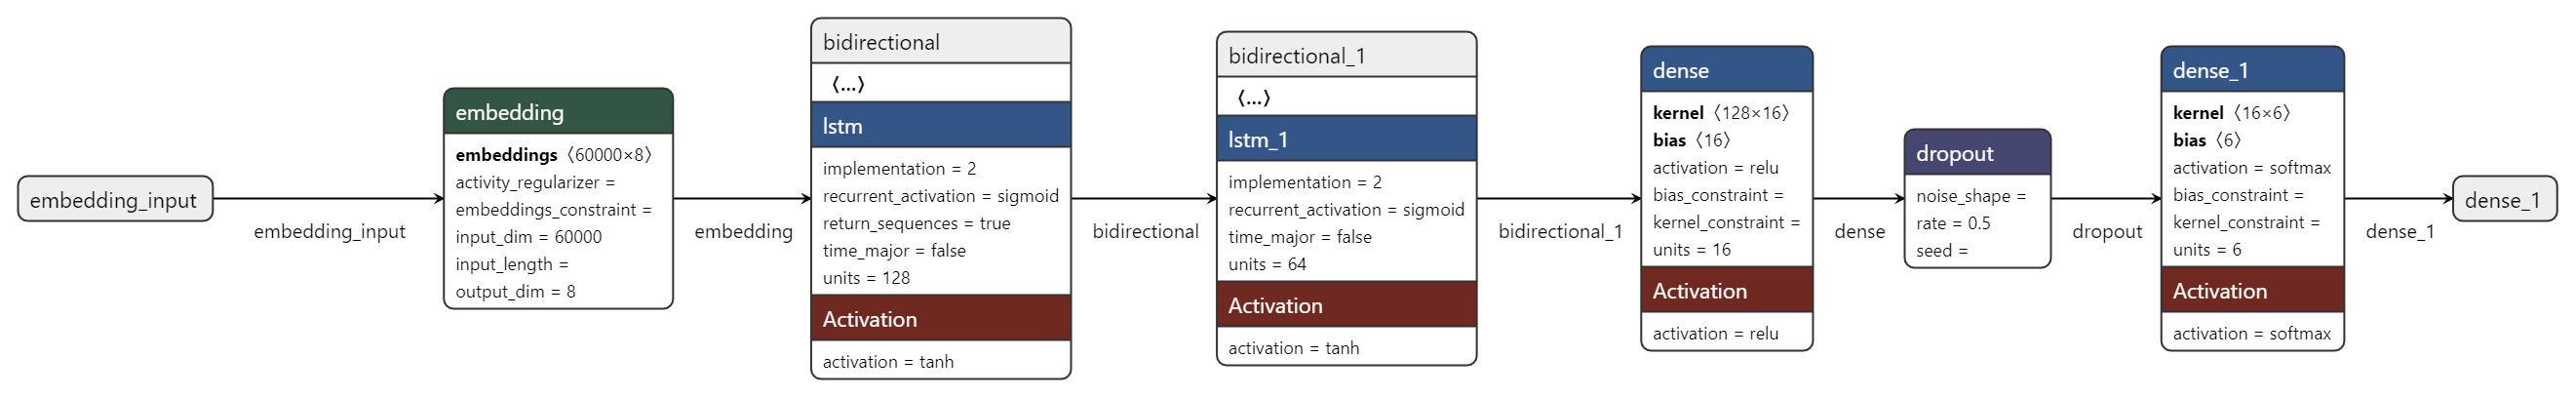

In [101]:
# Looping untuk mendapatkan bobot dari setiap layer
for layer in model.layers:
    # Mengecek apakah layer memiliki bobot
    if layer.weights:
        print("Layer Name:", layer.name)
        # Mendapatkan bobot dan bias dari layer
        weights = layer.get_weights()
        for i, w in enumerate(weights):
            print("Weights Shape (Tensor {}):".format(i), w.shape)
            print("Weights (Tensor {}):".format(i))
            print(w)


Layer Name: embedding_3
Weights Shape (Tensor 0): (60000, 8)
Weights (Tensor 0):
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-3.1991687  -1.3832113  -4.229323   ... -0.7926613   5.401962
   0.73388845]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Layer Name: bidirectional_6
Weights Shape (Tensor 0): (8, 512)
Weights (Tensor 0):
[[ 0.096361    0.01265421 -0.02091943 ... -0.04643566 -0.04017298
  -0.08873247]
 [-0.08828209  0.0848969  -0.02940919 ...  0.07290415  0.06746425
   0.05065734]
 [ 0.07949447  0.00776555 -0.04287801 ... -0.04277618 -0.00099081
  -0.06619808]
 ...
 [ 0.08279491  0.0414434   0.04493157 ...  0.10533831  0.10554751
  -0.00154942]
 [ 0.10248142 -0.04641474 -0.02080634 ... -0.05525606  0.

## Train Model

In [111]:
num_epochs = 20

history = model.fit(
    train_padded, 
    y_train, 
    batch_size=128, 
    epochs=num_epochs, 
    validation_data=(valid_padded, y_valid), 
)

Epoch 1/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 87s 218ms/step - accuracy: 0.6529 - loss: 0.9123 - val_accuracy: 0.6162 - val_loss: 1.1304
Epoch 2/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 82s 206ms/step - accuracy: 0.6705 - loss: 0.8769 - val_accuracy: 0.6183 - val_loss: 1.1742
Epoch 3/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 83s 209ms/step - accuracy: 0.6702 - loss: 0.8564 - val_accuracy: 0.6204 - val_loss: 1.1584
Epoch 4/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 79s 199ms/step - accuracy: 0.6803 - loss: 0.8338 - val_accuracy: 0.6187 - val_loss: 1.1849
Epoch 5/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 79s 198ms/step - accuracy: 0.6908 - loss: 0.8111 - val_accuracy: 0.6236 - val_loss: 1.1755
Epoch 6/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 80s 200ms/step - accuracy: 0.6993 - loss: 0.7883 - val_accuracy: 0.6294 - val_loss: 1.2105
Epoch 7/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 81s 203ms/step - accuracy: 0.7071 - loss: 0.7621 - val_accuracy: 0.6202 - val_loss: 1.2464
Epoch 8/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 80s 200ms/step - accuracy: 0.7123 - loss: 0

KeyboardInterrupt: 

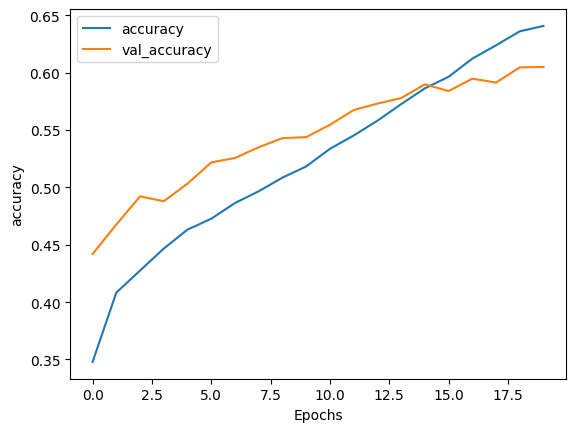

In [103]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")

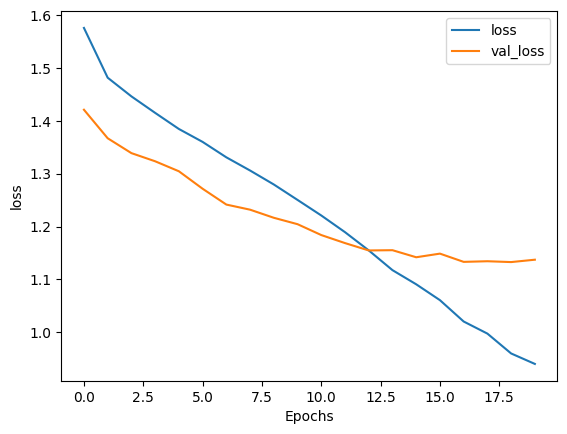

In [104]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "loss")

In [105]:
#sklearn report
from sklearn.metrics import classification_report

loss, accuracy = model.evaluate(valid_padded, y_valid)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

y_pred = model.predict(valid_padded)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_valid, y_pred))

178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.5971 - loss: 1.1657
Loss:  1.1374545097351074
Accuracy:  0.6050775647163391
178/178 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step
              precision    recall  f1-score   support

           0       0.58      0.47      0.52      1084
           1       0.49      0.66      0.56      1017
           2       0.63      0.59      0.61       936
           3       0.72      0.73      0.72       923
           4       0.71      0.64      0.68       865
           5       0.56      0.55      0.56       847

    accuracy                           0.61      5672
   macro avg       0.62      0.61      0.61      5672
weighted avg       0.61      0.61      0.61      5672



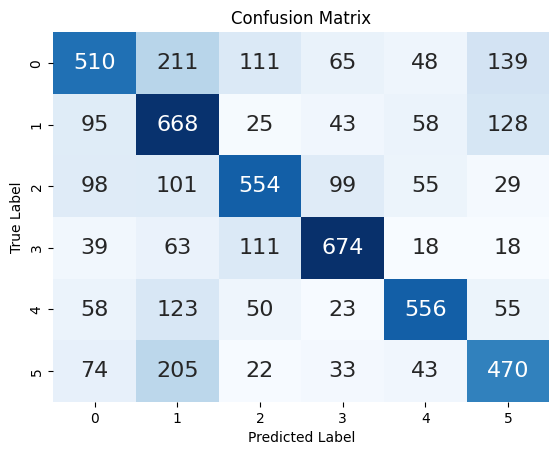

In [106]:
# create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Membuat confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# Membuat heatmap dari confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [107]:
print(cm)

[[510 211 111  65  48 139]
 [ 95 668  25  43  58 128]
 [ 98 101 554  99  55  29]
 [ 39  63 111 674  18  18]
 [ 58 123  50  23 556  55]
 [ 74 205  22  33  43 470]]


In [108]:
#predict another data input from the model
def predict_emotion(text):
    # Tokenisasi
    text = [text]
    sequences = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type, padding="post")
    
    # Prediksi
    pred = model.predict(padded)

    print("Prediksi:", pred)
    pred = np.argmax(pred, axis=1)
    

    # Mengembalikan label emosi
    if pred == 0:
        return "Neutral"
    elif pred == 1:
        return "Anger"
    elif pred == 2:
        return "Joy"
    elif pred == 3:
        return "Love"
    elif pred == 4:
        return "Sad"
    elif pred == 5:
        return "Fear"

#make 10 senteces twitter in predict emotion
predict_emotion("saya takut dengan hantu")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediksi: [[1.6330535e-02 9.8341482e-04 1.3142222e-05 2.9354930e-10 6.0990785e-04
  9.8206294e-01]]


'Fear'

In [109]:
#save model
model.save('./model/model-bilstm.h5')

In [110]:
import pickle

with open('tokenizer-emotion.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
